### Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

### Chargement données

In [3]:
sources=pd.read_csv('../Projet2/data/EdStatsCountry-Series.csv')
sources['Unnamed: 3'].unique()
sources.head()

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.,NaN
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population...,NaN


In [4]:
country_stats=pd.read_csv('../Projet2/data/EdStatsCountry.csv')
country_stats.head()

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2010.0,2012.0,2006,NaN
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,2011. Population figures compiled from adminis...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN,NaN


In [5]:
indicateurs=pd.read_csv('../Projet2/data/EdStatsData.csv')
indicateurs.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
notes_indicateurs=pd.read_csv('../Projet2/data/EdStatsFootNote.csv')
notes_indicateurs.head()

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.,NaN
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.,NaN


In [7]:
series=pd.read_csv('../Projet2/data/EdStatsSeries.csv')
series.head()

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAR.NOED.15UP.ZS,Attainment,Barro-Lee: Percentage of population age 15+ wi...,Percentage of population age 15+ with no educa...,Percentage of population age 15+ with no educa...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAR.NOED.2024.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 20-24 with...,Percentage of female population age 20-24 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Complétude des datasets

#### sources (EdStatsCountry-Series)

In [8]:
print('Dataset : sources','\n', 'Nombre de lignes : ',sources.shape[0],'\n','Nombre de colonnes : ', sources.shape[1])

Dataset : sources 
 Nombre de lignes :  613 
 Nombre de colonnes :  4


In [9]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


In [10]:
print('Nombre de lignes dupliquées = ', sources.duplicated(subset=['CountryCode','SeriesCode']).sum())

Nombre de lignes dupliquées =  0


Le dataset "sources" issu de EdStatsCountry-Series est globalement de bonne qualité. Seule la colonne 'Unnamed: 3" contient des Nans et il n'y a pas de lignes dupliquées.

In [73]:
#Suppression des colonnes vides
sources.dropna(axis=1,how='all',inplace=True)

#### country_stats (EdStatsCountry)

In [11]:
print('Dataset : country_stats','\n','Nombre de lignes : ',country_stats.shape[0],'\n','Nombre de colonnes : ', country_stats.shape[1])

Dataset : country_stats 
 Nombre de lignes :  241 
 Nombre de colonnes :  32


In [12]:
country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

In [13]:
#Colonnes vides :
country_stats.loc[:,country_stats.isna().all()].columns

Index(['Unnamed: 31'], dtype='object')

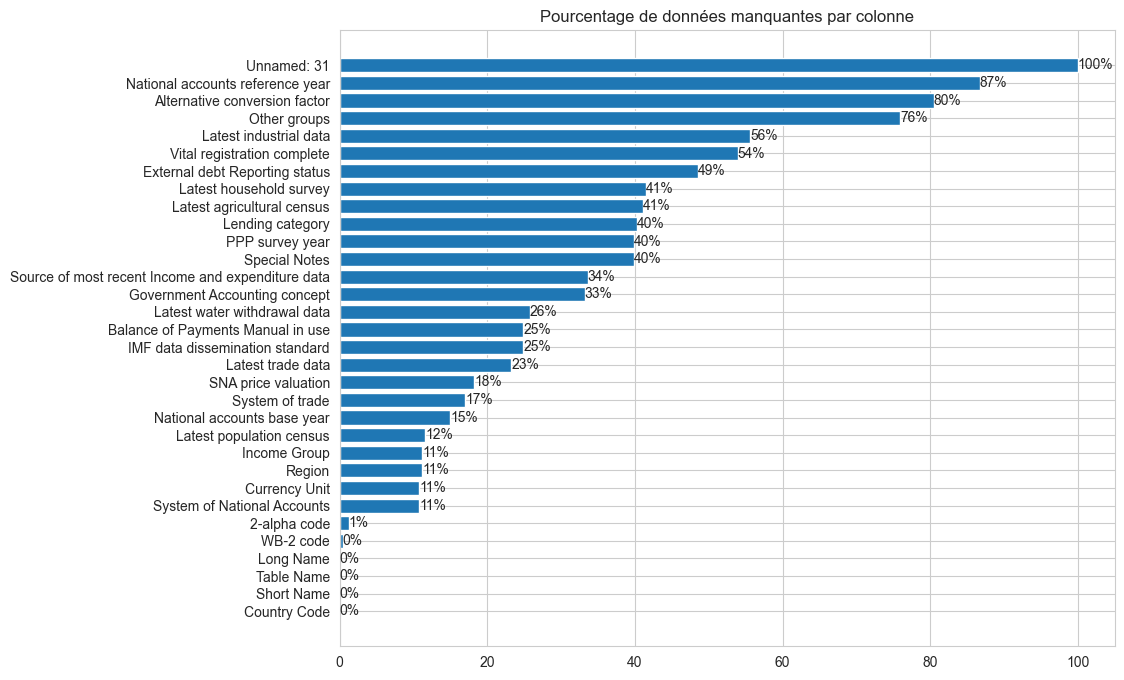

In [14]:
#Données manquantes
pourcentage_manquantes_country=100*country_stats.isna().sum().sort_values()/country_stats.shape[0]

plt.figure(figsize=(10,8))
fig=plt.barh(pourcentage_manquantes_country.index,pourcentage_manquantes_country)
plt.title('Pourcentage de données manquantes par colonne')
plt.bar_label(fig,fmt='{0:.0f}%')
plt.show()


In [15]:
print('Nombre de lignes dupliquées = ', country_stats.duplicated(subset=['Country Code']).sum())

Nombre de lignes dupliquées =  0


Parmi les colonnes disponibles : Country Code, Short Name, Table Name et Long Name sont completes. 
Les autres colonnes présentent beaucoup de données manquantes. Il n'y a pas de lignes dupliquées.

In [74]:
#Suppression des colonnes vides
country_stats.dropna(axis=1,how='all',inplace=True)

#### indicateurs (EdStatsData)

In [16]:
print('Dataset : indicateurs','\n','Nombre de lignes : ',indicateurs.shape[0],'\n','Nombre de colonnes : ', indicateurs.shape[1])

Dataset : indicateurs 
 Nombre de lignes :  886930 
 Nombre de colonnes :  70


In [17]:
indicateurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

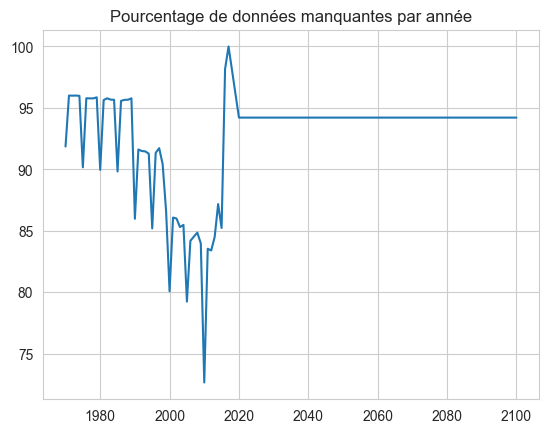

In [18]:
#Données manquantes :

filtre=[col.isdigit() for col in indicateurs.columns]
pourcentage_manquantes_ind=100*indicateurs.loc[:,filtre].isna().sum()/indicateurs.shape[0]
pourcentage_manquantes_ind.index=pd.to_datetime(pourcentage_manquantes_ind.index)

plt.plot(pourcentage_manquantes_ind.index,pourcentage_manquantes_ind)
plt.title('Pourcentage de données manquantes par année')
plt.show()


In [19]:
print('Nombre de lignes dupliquées = ', indicateurs.duplicated(subset=['Country Code','Indicator Code']).sum())

Nombre de lignes dupliquées =  0


Parmi les colonnes disponibles : Country Name, Country Code, Indicator Name  et Indicator Code sont completes. Les données par année présentent beaucoup de données manquantes (>70%). Il n'y a pas de lignes dupliquées.

In [75]:
#Suppression des colonnes vides
indicateurs.dropna(axis=1,how='all',inplace=True)

#### notes_indicateurs (EdStatsFootNote)

In [20]:
print('Dataset : notes_indicateurs','\n','Nombre de lignes : ',notes_indicateurs.shape[0],'\n','Nombre de colonnes : ', notes_indicateurs.shape[1])

Dataset : notes_indicateurs 
 Nombre de lignes :  643638 
 Nombre de colonnes :  5


In [21]:
notes_indicateurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


In [22]:
print('Nombre de lignes dupliquées = ', notes_indicateurs.duplicated(subset=['CountryCode','SeriesCode','Year']).sum())

Nombre de lignes dupliquées =  0


Le dataset "notes_indicateurs" est globalement de bonne qualité. Seule la colonne 'Unnamed: 4" contient des Nans et il n'y a pas de lignes dupliquées.

In [76]:
#Suppression des colonnes vides
notes_indicateurs.dropna(axis=1,how='all',inplace=True)

#### series (EdStatsSeries)

In [23]:
print('Dataset : notes_indicateurs','\n','Nombre de lignes : ',series.shape[0],'\n','Nombre de colonnes : ', series.shape[1])

Dataset : notes_indicateurs 
 Nombre de lignes :  3665 
 Nombre de colonnes :  21


In [24]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

In [25]:
#Colonnes vides :
series.loc[:,series.isna().all()].columns

Index(['Unit of measure', 'Notes from original source', 'Other web links',
       'Related indicators', 'License Type', 'Unnamed: 20'],
      dtype='object')

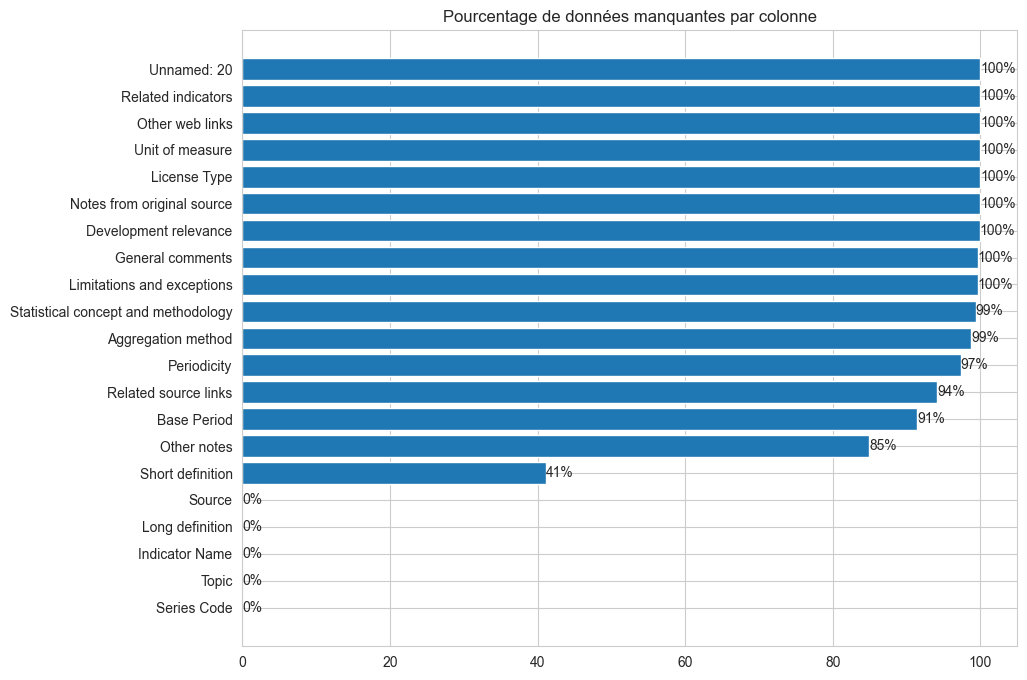

In [26]:
#Données manquantes
pourcentage_manquantes_series=100*series.isna().sum().sort_values()/series.shape[0]

plt.figure(figsize=(10,8))
fig=plt.barh(pourcentage_manquantes_series.index,pourcentage_manquantes_series)
plt.title('Pourcentage de données manquantes par colonne')
plt.bar_label(fig,fmt='{0:.0f}%')
plt.show()

In [27]:
print('Nombre de lignes dupliquées = ', series.duplicated(subset=['Series Code']).sum())

Nombre de lignes dupliquées =  0


Parmi les colonnes disponibles : Series Code, Topic, Indicator Name, Long definition et Source sont completes. Short definition est partiellement renseignée (41% de données manquantes). Les autres colonnes présentent un taux élévé de Nans (>=85%) ou sont vides.

In [77]:
#Suppression des colonnes vides
series.dropna(axis=1,how='all',inplace=True)

### Selection des données pertinentes

#### Indicateurs annuels

In [78]:
indicateurs['Indicator Name'].unique()[1000:].tolist()

['EGRA: Oral Reading Fluency - Share of students with a zero score (%). Sidaamu Afoo. 2nd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Sidaamu Afoo. 3rd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Silozi. 2nd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Somaligna. 2nd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Somaligna. 3rd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Songhoi. 2nd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Spanish. 2nd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Spanish. 3rd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Spanish. 4th Grade',
 'EGRA: Oral Reading Fluency - Share of students with a zero score (%). Tigrinya. 2nd Grade',
 'EGRA: Oral Reading Fluency - Share of students with a 

In [79]:
#Labels intéressants :

indicateurs_souhaites=indicateurs['Indicator Name'].isin([
'Adjusted net enrolment rate, upper secondary, both sexes (%)',
'Adult literacy rate, population 15+ years, both sexes (%)',
'Barro-Lee: Average years of secondary schooling, age 25+, total',
'Barro-Lee: Average years of tertiary schooling, age 75+, total',
'Barro-Lee: Percentage of population age 15-19 with secondary schooling. Total (Incomplete and Completed Secondary)',
'Barro-Lee: Percentage of population age 25-29 with secondary schooling. Completed Secondary',
'Barro-Lee: Percentage of population age 25-29 with tertiary schooling. Total (Incomplete and Completed Tertiary)',
'Barro-Lee: Percentage of population age 75+ with tertiary schooling. Total (Incomplete and Completed Tertiary)',
'DHS: Average years of schooling by age group. Age 15-19',
'DHS: Secondary completion rate',
'Duration of compulsory education (years)',
'Enrolment in secondary education, both sexes (number)',
'Enrolment in tertiary education, all programmes, both sexes (number)',
'Internet users (per 100 people)',
'MICS: Secondary completion rate',
'Personal computers (per 100 people)',
'PISA: Mean performance on the mathematics scale',
'PISA: Mean performance on the reading scale',
'PISA: Mean performance on the science scale',
'Population, total',
'Pupil-teacher ratio in tertiary education (headcount basis)',
'Pupil-teacher ratio in upper secondary education (headcount basis)',
'SACMEQ: Mean performance on the mathematics scale',
'SACMEQ: Mean performance on the reading scale, total',
'UIS: Mean years of schooling of the population age 25+. Total',
"UIS: Percentage of population age 25+ with at least a completed bachelor's or equivalent degree (ISCED 6 or higher). Total",
'UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total'])


#% de données disponibles pour ces indicateurs :

nbr_colonnes=len(indicateurs[indicateurs_souhaites].groupby('Indicator Name').count().columns)
nbr_pays=len(indicateurs['Country Name'].unique())

(indicateurs[indicateurs_souhaites].groupby('Indicator Name').count().sum(axis=1)/(nbr_pays*nbr_colonnes)*100).round(1).sort_values(ascending=False)

Indicator Name
Population, total                                                                                                             72.2
Enrolment in secondary education, both sexes (number)                                                                         49.4
Enrolment in tertiary education, all programmes, both sexes (number)                                                          44.6
Internet users (per 100 people)                                                                                               37.5
Pupil-teacher ratio in tertiary education (headcount basis)                                                                   26.5
Duration of compulsory education (years)                                                                                      25.3
Personal computers (per 100 people)                                                                                           21.4
Pupil-teacher ratio in upper secondary education (headcount basis)  

In [88]:
liste_retenus=[
    'Population, total',
    'Enrolment in secondary education, both sexes (number)' ,
    'Enrolment in tertiary education, all programmes, both sexes (number)' ,
    'Internet users (per 100 people)',
    'Pupil-teacher ratio in tertiary education (headcount basis)',
    'Duration of compulsory education (years)' ,'Personal computers (per 100 people)',
    'Pupil-teacher ratio in upper secondary education (headcount basis)']
filtre_retenus=indicateurs['Indicator Name'].isin(liste_retenus)
indicateurs_retenus=indicateurs[filtre_retenus]

#Colonnes non vides pour les indicateurs retenus
indicateurs_retenus.dropna(axis=1,how='all').columns



Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016'],
      dtype='object')

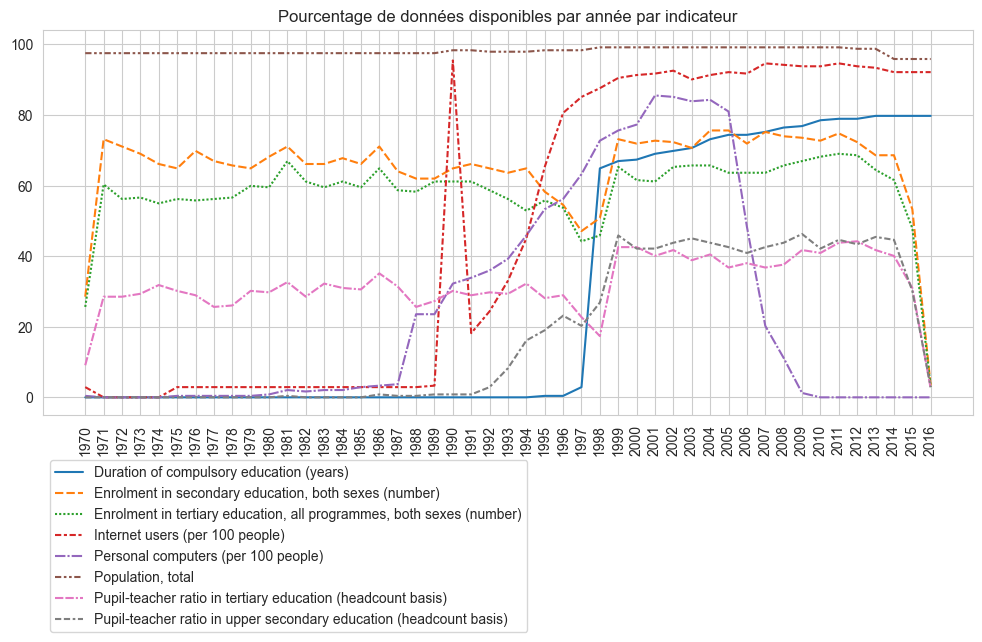

In [81]:
#Données disponibles :

temp=indicateurs_retenus.groupby('Indicator Name').count()
temp.loc[:,'1970':'2016'].T*100/nbr_pays


plt.figure(figsize=(12,5))
sns.lineplot(temp.loc[:,'1970':'2016'].T*100/nbr_pays) #calcul des pourcentages pour les années avec des données
plt.title('Pourcentage de données disponibles par année par indicateur')
plt.legend(loc='upper left',bbox_to_anchor=(0,-0.1))
plt.xticks(rotation = 90)
plt.show()

Les années 1999 à 2005 contiennent le plus grand nombre de données.
'Internet users' a des données plus récentes que 'Personal computers', pour lequel le nombre de données disponibles décroit rapidement à partir de 2005.
La dernière année avec un taux acceptable de données est 2014 si on exclue l'indicateur 'Personnal computers'.

In [82]:
series_retenus=series[series['Indicator Name'].isin(liste_retenus)].dropna(axis=1,how='all')
series_retenus

,Series Code,Topic,Indicator Name,Long definition,Periodicity,Aggregation method,Limitations and exceptions,General comments,Source
610,IT.CMP.PCMP.P2,Infrastructure: Communications,Personal computers (per 100 people),Personal computers are self-contained computer...,Annual,Weighted average,NaN,Restricted use: Please cite the International ...,"International Telecommunication Union, World T..."
611,IT.NET.USER.P2,Infrastructure: Communications,Internet users (per 100 people),Internet users are individuals who have used t...,Annual,Weighted average,Operators have traditionally been the main sou...,Please cite the International Telecommunicatio...,"International Telecommunication Union, World T..."
2216,SE.COM.DURS,Background,Duration of compulsory education (years),Number of years that children are legally obli...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
2294,SE.SEC.ENRL,Secondary,"Enrolment in secondary education, both sexes (...",Total number of students enrolled at public an...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
2332,SE.TER.ENRL,Tertiary,"Enrolment in tertiary education, all programme...",The total number of students enrolled at publi...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
2590,SP.POP.TOTL,Health: Population: Structure,"Population, total",Total population is based on the de facto defi...,Annual,Sum,Current population estimates for developing co...,Relevance to gender indicator: disaggregating ...,(1) United Nations Population Division. World ...
3282,UIS.PTRHC.3,Teachers,Pupil-teacher ratio in upper secondary educati...,Average number of pupils per teacher at a give...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
3285,UIS.PTRHC.56,Teachers,Pupil-teacher ratio in tertiary education (hea...,Average number of pupils per teacher at a give...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics


A part la population, les utilisateurs d'internet et le nombre d'ordinateurs personnels, le reste des indicateurs proviennent de la même source (UNESCO Institute for Statistics).

In [83]:
#Codes pour les indicateurs retenus :
dict_retenus=dict(zip(series_retenus['Indicator Name'],series_retenus['Series Code']))
dict_retenus

{'Personal computers (per 100 people)': 'IT.CMP.PCMP.P2',
 'Internet users (per 100 people)': 'IT.NET.USER.P2',
 'Duration of compulsory education (years)': 'SE.COM.DURS',
 'Enrolment in secondary education, both sexes (number)': 'SE.SEC.ENRL',
 'Enrolment in tertiary education, all programmes, both sexes (number)': 'SE.TER.ENRL',
 'Population, total': 'SP.POP.TOTL',
 'Pupil-teacher ratio in upper secondary education (headcount basis)': 'UIS.PTRHC.3',
 'Pupil-teacher ratio in tertiary education (headcount basis)': 'UIS.PTRHC.56'}

In [84]:
#Notes complémentaires par année pour ces
notes_retenus=notes_indicateurs.loc[notes_indicateurs['SeriesCode'].isin(series_retenus['Series Code'])]
notes_retenus.head()

,CountryCode,SeriesCode,Year,DESCRIPTION
99,ABW,SE.COM.DURS,YR1999,Country data
100,ABW,SE.COM.DURS,YR2000,Country data
101,ABW,SE.COM.DURS,YR2001,Country data
102,ABW,SE.COM.DURS,YR2002,Country data
103,ABW,SE.COM.DURS,YR2003,Country data


In [118]:
#Filtre sur les années avec le plus de données

#Afin de garder des données comparables tout en essayant de garder un maximum de données, la moyenne des valeurs des 
# indicateurs pour les 2 dernières années avec un nombre significatif de données (2013 et 2014) sera prise comme indicateur

colonnes_retenues=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2013','2014']

data=indicateurs_retenus.loc[:,colonnes_retenues]
data.dropna(axis=0,subset=['2013','2014'],how='all',inplace=True)
data['moy2013-2014']=(data['2013']+data['2014'])/2 #Ne fonctionne pas car Nan + value = Nan
data
#Nombre de valeurs manquantes
#data.isna().sum()


,Country Name,Country Code,Indicator Name,Indicator Code,2013,2014,moy2013-2014
1191,Arab World,ARB,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,3.125060e+07,3.097225e+07,3.111142e+07
1204,Arab World,ARB,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,9.688632e+06,9.966484e+06,9.827558e+06
1375,Arab World,ARB,Internet users (per 100 people),IT.NET.USER.P2,3.686860e+01,NaN,NaN
2533,Arab World,ARB,"Population, total",SP.POP.TOTL,3.697615e+08,NaN,NaN
2554,Arab World,ARB,Pupil-teacher ratio in upper secondary educati...,UIS.PTRHC.3,1.297931e+01,1.360266e+01,1.329099e+01
...,...,...,...,...,...,...,...
884456,Zimbabwe,ZWE,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,9.574610e+05,NaN,NaN
884469,Zimbabwe,ZWE,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,9.411500e+04,NaN,NaN
884640,Zimbabwe,ZWE,Internet users (per 100 people),IT.NET.USER.P2,1.550000e+01,1.636474e+01,1.593237e+01
885798,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,1.505451e+07,1.541168e+07,1.523309e+07


### Nettoyage